In [28]:
import os
import sys

root_folder = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_folder)

print(sys.path)

import numpy as np
import numpy.linalg as la
import numpy.matlib as matl
import matplotlib.pyplot as plt

from optimization.ff_scenario_obs import start_region, goal_region, n_time_rpod, obs_list, N_STATE, N_ACTION, N_OBS_MAX, SINGLE_OBS_DIM, iter_max_SCP, robot_radius, safety_margin

rl = True
save_plots = False
traj_data = np.load(root_folder + '/optimization/saved_files/warmstarting_sum_after_embed_14_scenarios/ws_analysis_checkpoint_ff_obs_ctgrtg_dyn1000.npz')

n = len(traj_data['test_dataset_ix'])#20001#
    
J_vect_scp_cvx = traj_data['J_vect_scp_cvx'][:n]
J_vect_scp_DT =  traj_data['J_vect_scp_DT'][:n]
J_cvx =  traj_data['J_cvx'][:n]
J_DT =  traj_data['J_DT'][:n]
iter_scp_cvx =  traj_data['iter_scp_cvx'][:n]
iter_scp_DT =  traj_data['iter_scp_DT'][:n]
runtime_cvx =  traj_data['runtime_cvx'][:n]
runtime_DT =  traj_data['runtime_DT'][:n]
runtime_scp_cvx =  traj_data['runtime_scp_cvx'][:n]
runtime_scp_DT =  traj_data['runtime_scp_DT'][:n]
ctgs0_cvx =  traj_data['ctgs0_cvx'][:n]
cvx_problem =  traj_data['cvx_problem'][:n]
test_dataset_ix =  np.arange(len(traj_data['test_dataset_ix'][:n]))
i_unfeas_cvx =  traj_data['i_unfeas_cvx'][:n]
i_unfeas_scp_cvx =  traj_data['i_unfeas_scp_cvx'][:n]
i_unfeas_DT =  traj_data['i_unfeas_DT'][:n]
x_init = traj_data['state_init']
x_final = traj_data['state_final']


['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/amir/freeflyer2/tr4ff/lib/python3.10/site-packages', '/home/amir/freeflyer2/ff_control/transformer_controller', '/home/amir/freeflyer2/ff_control/transformer_controller', '/home/amir/freeflyer2/ff_control/transformer_controller', '/home/amir/freeflyer2/ff_control/transformer_controller', '/home/amir/freeflyer2/ff_control/transformer_controller']


In [29]:
len(i_unfeas_scp_cvx)/n*100, n


(5.800000000000001, 2000)

In [30]:
len(i_unfeas_scp_cvx), len(i_unfeas_cvx), len(i_unfeas_DT)

(116, 0, 132)

In [31]:
set_unf_scp_cvx = set(i_unfeas_scp_cvx)
set_unf_scp_DT = set(i_unfeas_DT)
i_unfeas_cvx_DT = list(set_unf_scp_cvx - set_unf_scp_DT)

In [32]:
x_init_infeas_scp_cvx = x_init[i_unfeas_scp_cvx]
x_init_infeas_scp_DT = x_init[i_unfeas_DT]
x_final_infeas_scp_cvx = x_final[i_unfeas_scp_cvx]
x_final_infeas_scp_DT = x_final[i_unfeas_DT]

In [33]:
unfeas_lines = np.concatenate((x_init_infeas_scp_cvx[:,:,None], x_final_infeas_scp_cvx[:,:,None]), axis=2)
unfeas_lines_DT = np.concatenate((x_init_infeas_scp_DT[:,:,None], x_final_infeas_scp_DT[:,:,None]), axis=2)

In [34]:
n_obs = 4
obs = obs_list[0]

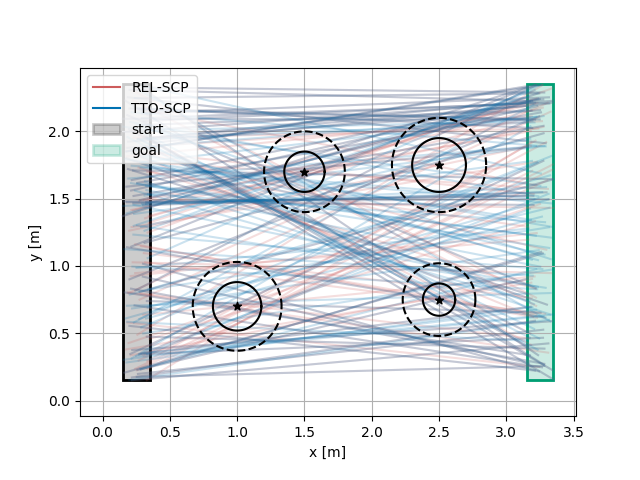

In [35]:
%matplotlib ipympl
from matplotlib.patches import Circle, Rectangle
plt.style.use('seaborn-v0_8-colorblind')
plt.figure()
dim1 = 0
dim2 = 1
ax = plt.axes()#projection='3d')
#ax.scatter3D(x_init_infeas_scp_cvx[:,0],x_init_infeas_scp_cvx[:,1],x_init_infeas_scp_cvx[:,2])
ax.plot(unfeas_lines[:,dim1,:].T, unfeas_lines[:,dim2,:].T, c='indianred', alpha=0.2)#, unfeas_lines[:,2,:].T)
ax.plot(unfeas_lines_DT[:,dim1,:].T, unfeas_lines_DT[:,dim2,:].T, c='C0', alpha=0.2)
ax.plot(0, 0, c='indianred', label='REL-SCP')
ax.plot(0, 0, c='C0', label='TTO-SCP')
ax.add_patch(Rectangle(start_region['xy_low'], start_region['xy_up'][0] - start_region['xy_low'][0], start_region['xy_up'][1] - start_region['xy_low'][1], fc ='none', ec ='black', alpha=1., lw = 2, zorder=1))
ax.add_patch(Rectangle(goal_region['xy_low'], goal_region['xy_up'][0] - goal_region['xy_low'][0], goal_region['xy_up'][1] - goal_region['xy_low'][1], fc ='none', ec ='C1', alpha=1., lw = 2, zorder=1))
ax.add_patch(Rectangle(start_region['xy_low'], start_region['xy_up'][0] - start_region['xy_low'][0], start_region['xy_up'][1] - start_region['xy_low'][1], fc ='black', ec ='black', alpha=0.2, lw = 2, zorder=1, label='start'))
ax.add_patch(Rectangle(goal_region['xy_low'], goal_region['xy_up'][0] - goal_region['xy_low'][0], goal_region['xy_up'][1] - goal_region['xy_low'][1], fc ='C1', ec ='C1', alpha=0.2, lw = 2, zorder=1, label='goal')) 
ax.set_aspect('equal')
for i in range(n_obs):
    p = obs['position'][i]
    r = obs['radius'][i]
    r_plus = (obs['radius'][i] + robot_radius)
    ax.scatter(p[dim1],p[dim2],marker='*',color='k', zorder=3)
    ax.plot(p[dim1]+r*np.cos(np.linspace(0,2*np.pi,100)), p[dim2]+r*np.sin(np.linspace(0,2*np.pi,100)), c='k', zorder=4)
    ax.plot(p[dim1]+r_plus*np.cos(np.linspace(0,2*np.pi,100)), p[dim2]+r_plus*np.sin(np.linspace(0,2*np.pi,100)), 'k--', zorder=4)
ax.grid(True)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend(loc='upper left')
plt.show()

In [36]:
J_cvx_feas_sort

array([0.15447205, 0.15496005, 0.15643835, ..., 0.28456236, 0.28505447,
       0.28514034])

In [38]:
####### Full feasible nncvx testset analysis

# i_unfeas = list(set(i_unfeas_scp_cvx).union(set(i_unfeas_DT)))
wrong_opt_cases = np.min(J_vect_scp_cvx, axis=1) > 200
i_unfeas2 = list(set(i_unfeas_scp_cvx).union(set(i_unfeas_DT)).union(set(np.rint(test_dataset_ix[wrong_opt_cases]).astype(int))))
i_unfeas = i_unfeas2
i_unfeas_plus_cvx = list(set(i_unfeas).union(set(np.rint(test_dataset_ix[cvx_problem]).astype(int))))


ctgs0_cvx_feas = np.delete(ctgs0_cvx, i_unfeas_plus_cvx, axis=0)
J_vect_scp_cvx_feas = np.delete(J_vect_scp_cvx, i_unfeas_plus_cvx, axis=0)
J_vect_scp_DT_feas = np.delete(J_vect_scp_DT, i_unfeas_plus_cvx, axis=0)
J_cvx_feas = np.delete(J_cvx, i_unfeas_plus_cvx, axis=0)
J_DT_feas = np.delete(J_DT, i_unfeas_plus_cvx, axis=0)
iter_scp_cvx_feas = np.delete(iter_scp_cvx, i_unfeas_plus_cvx, axis=0)
iter_scp_DT_feas = np.delete(iter_scp_DT, i_unfeas_plus_cvx, axis=0)
runtime_cvx_feas = np.delete(runtime_cvx, i_unfeas_plus_cvx, axis=0)
runtime_scp_cvx_feas = np.delete(runtime_scp_cvx, i_unfeas_plus_cvx, axis=0)
runtime_DT_feas = np.delete(runtime_DT, i_unfeas_plus_cvx, axis=0)
runtime_scp_DT_feas = np.delete(runtime_scp_DT, i_unfeas_plus_cvx, axis=0)

print('Full feasible nncvx testset analysis. Test dataset size: ', len(ctgs0_cvx_feas))

J_min_scp_cvx_feas = np.min(J_vect_scp_cvx_feas, axis=1)
J_min_scp_DT_feas = np.min(J_vect_scp_DT_feas, axis=1)

J_scp_gain_mean = np.mean(J_min_scp_cvx_feas - J_min_scp_DT_feas)
J_scp_gain_std = np.std(J_min_scp_cvx_feas - J_min_scp_DT_feas)
print('J_scp_gain_mean:', J_scp_gain_mean, 'J_scp_gain_std:', J_scp_gain_std)

J_scp_gain_mean_perc = np.mean((J_min_scp_cvx_feas - J_min_scp_DT_feas)/J_min_scp_cvx_feas*100)
print('idx max cost perc improvement: ', test_dataset_ix[J_cvx==J_cvx_feas[np.argmax((J_min_scp_cvx_feas - J_min_scp_DT_feas)/J_min_scp_cvx_feas)]])
ix_sort = np.argsort(-(J_min_scp_cvx_feas - J_min_scp_DT_feas)/J_min_scp_cvx_feas)
print('First ten i with maximum cost perc improvement: ', test_dataset_ix[np.isin(J_cvx, J_cvx_feas[ix_sort][:10])])
J_scp_gain_std_perc = np.std((J_min_scp_cvx_feas - J_min_scp_DT_feas)/J_min_scp_cvx_feas*100)
print('J_scp_gain_mean_perc: ', J_scp_gain_mean_perc, ' J_scp_gain_std_perc: ', J_scp_gain_std_perc)

iter_scp_mean_cvx = np.mean(iter_scp_cvx_feas)
iter_scp_mean_DT = np.mean(iter_scp_DT_feas)
iter_scp_gain_mean = np.mean(iter_scp_cvx_feas - iter_scp_DT_feas)
iter_scp_gain_std = np.std(iter_scp_cvx_feas - iter_scp_DT_feas)
print('iter_gain_mean: ', iter_scp_gain_mean, ' iter_gain_std: ', iter_scp_gain_std)
print('iter_scp_mean_cvx: ', iter_scp_mean_cvx, ' iter_scp_mean_DT : ', iter_scp_mean_DT)

runtime_scp_mean_cvx = np.mean(runtime_cvx_feas + runtime_scp_cvx_feas)
runtime_scp_mean_DT = np.mean(runtime_DT_feas + runtime_scp_DT_feas)
runtime_gain_mean = np.mean((runtime_cvx_feas + runtime_scp_cvx_feas) - (runtime_DT_feas + runtime_scp_DT_feas))
runtime_gain_std = np.std((runtime_cvx_feas + runtime_scp_cvx_feas) - (runtime_DT_feas + runtime_scp_DT_feas))
print('runtime_gain_mean: ', runtime_gain_mean, ' runtime_gain_std: ', runtime_gain_std)
print('runtime_scp_mean_cvx: ', runtime_scp_mean_cvx, ' runtime_scp_mean_DT: ', runtime_scp_mean_DT)

ind_sort_J_cvx_feas = np.argsort(J_cvx_feas)
J_cvx_feas_sort = J_cvx_feas[ind_sort_J_cvx_feas]
perc_opt_loss_DT = (J_DT_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
perc_opt_loss_scp_cvx = (J_min_scp_cvx_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
perc_opt_loss_scp_DT  = (J_min_scp_DT_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100

ind_sort_ctgs0_cvx = np.argsort(ctgs0_cvx_feas)
ctgs0_cvx_sort = ctgs0_cvx_feas[ind_sort_ctgs0_cvx]
perc_opt_loss_DT_ctgs = (J_DT_feas[ind_sort_ctgs0_cvx]-J_cvx_feas[ind_sort_ctgs0_cvx])/J_cvx_feas[ind_sort_ctgs0_cvx]*100
perc_opt_loss_scp_cvx_ctgs = (J_min_scp_cvx_feas[ind_sort_ctgs0_cvx]-J_cvx_feas[ind_sort_ctgs0_cvx])/J_cvx_feas[ind_sort_ctgs0_cvx]*100
perc_opt_loss_scp_DT_ctgs  = (J_min_scp_DT_feas[ind_sort_ctgs0_cvx]-J_cvx_feas[ind_sort_ctgs0_cvx])/J_cvx_feas[ind_sort_ctgs0_cvx]*100

perc_cost_gain_ctgs = (J_min_scp_cvx_feas[ind_sort_ctgs0_cvx] - J_min_scp_DT_feas[ind_sort_ctgs0_cvx])/J_min_scp_cvx_feas[ind_sort_ctgs0_cvx]*100
iter_gain_ctgs = (iter_scp_cvx_feas[ind_sort_ctgs0_cvx] - iter_scp_DT_feas[ind_sort_ctgs0_cvx])
perc_runtime_gain_ctgs = (runtime_scp_cvx_feas[ind_sort_ctgs0_cvx] - runtime_scp_DT_feas[ind_sort_ctgs0_cvx])/runtime_scp_cvx_feas[ind_sort_ctgs0_cvx]*100

Delta_J_mean_scp_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float) 
Delta_J_std_scp_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float)
count_scp_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float)
Delta_J_mean_scp_DT = np.zeros(shape=(iter_max_SCP,), dtype=float) 
Delta_J_std_scp_DT = np.zeros(shape=(iter_max_SCP,), dtype=float)
count_scp_DT = np.zeros(shape=(iter_max_SCP,), dtype=float)
Delta_J_mean_scp_cvx_2_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float) 
Delta_J_std_scp_cvx_2_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float)
Delta_J_mean_scp_DT_2_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float) 
Delta_J_std_scp_DT_2_cvx = np.zeros(shape=(iter_max_SCP,), dtype=float)
Delta_J_mean_DT_2_cvx = np.mean((J_DT_feas - J_cvx_feas)/J_cvx_feas)
Delta_J_std_DT_2_cvx = np.std((J_DT_feas - J_cvx_feas)/J_cvx_feas)

for i in range(iter_max_SCP):
    mask_scp_cvx_i = J_vect_scp_cvx_feas[:,i] > 1e10
    count_scp_cvx[i] = sum(~mask_scp_cvx_i)
    J_vect_scp_cvx_feas_i = J_vect_scp_cvx_feas[:,i].copy()
    J_vect_scp_cvx_feas_i[mask_scp_cvx_i] = J_min_scp_cvx_feas[mask_scp_cvx_i]
    Delta_J_mean_scp_cvx[i] = np.mean((J_vect_scp_cvx_feas_i-J_min_scp_cvx_feas)/J_min_scp_cvx_feas)
    Delta_J_std_scp_cvx[i] = np.std((J_vect_scp_cvx_feas_i-J_min_scp_cvx_feas)/J_min_scp_cvx_feas)
    Delta_J_mean_scp_cvx_2_cvx[i] = np.mean((J_vect_scp_cvx_feas_i-J_cvx_feas)/J_cvx_feas)
    Delta_J_std_scp_cvx_2_cvx[i] = np.std((J_vect_scp_cvx_feas_i-J_cvx_feas)/J_cvx_feas)
    mask_scp_DT_i = J_vect_scp_DT_feas[:,i] > 1e10
    count_scp_DT[i] = sum(~mask_scp_DT_i)
    J_vect_scp_DT_feas_i = J_vect_scp_DT_feas[:,i].copy()
    J_vect_scp_DT_feas_i[mask_scp_DT_i] = J_min_scp_DT_feas[mask_scp_DT_i]
    Delta_J_mean_scp_DT[i] = np.mean((J_vect_scp_DT_feas_i-J_min_scp_DT_feas)/J_min_scp_DT_feas)
    Delta_J_std_scp_DT[i] = np.std((J_vect_scp_DT_feas_i-J_min_scp_DT_feas)/J_min_scp_DT_feas)
    Delta_J_mean_scp_DT_2_cvx[i] = np.mean((J_vect_scp_DT_feas_i-J_cvx_feas)/J_cvx_feas)
    Delta_J_std_scp_DT_2_cvx[i] = np.std((J_vect_scp_DT_feas_i-J_cvx_feas)/J_cvx_feas)


Full feasible nncvx testset analysis. Test dataset size:  1756
J_scp_gain_mean: 0.00020109513080982265 J_scp_gain_std: 0.0122795382049109
idx max cost perc improvement:  [1616 1617]
First ten i with maximum cost perc improvement:  [1015 1031 1077 1204 1210 1211 1212 1213 1215 1216 1217 1218 1219 1232
 1234 1238 1239 1242 1243 1244 1245 1246 1247 1248 1252 1253 1254 1256
 1257 1258 1259 1268 1269 1274 1286 1287 1288 1292 1293 1294 1295 1296
 1297 1299 1300 1301 1302 1303 1310 1314 1315 1320 1326 1327 1328 1329
 1330 1331 1332 1336 1337 1338 1340 1341 1342 1343 1348 1352 1353 1356
 1357 1420 1556 1566 1572 1573 1574 1575 1577 1578 1579 1580 1581 1598
 1600 1604 1605 1608 1609 1610 1611 1612 1613 1614 1616 1617 1618 1619
 1620 1622 1623 1624 1625 1634 1635 1638 1639 1784 1844 1850 1851 1852
 1853 1855 1856 1857 1858 1859 1872 1874 1878 1879 1882 1883 1884 1885
 1886 1887 1888 1892 1893 1894 1896 1897 1898 1899 1908 1909 1914 1926
 1927 1928 1932 1933 1934 1935 1936 1937 1939 1940 1941 194

/tmp/ipykernel_1025079/1056396936.py:54: RuntimeWarning: divide by zero encountered in divide
  perc_opt_loss_DT = (J_DT_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
/tmp/ipykernel_1025079/1056396936.py:54: RuntimeWarning: overflow encountered in divide
  perc_opt_loss_DT = (J_DT_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
/tmp/ipykernel_1025079/1056396936.py:54: RuntimeWarning: invalid value encountered in divide
  perc_opt_loss_DT = (J_DT_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
/tmp/ipykernel_1025079/1056396936.py:55: RuntimeWarning: divide by zero encountered in divide
  perc_opt_loss_scp_cvx = (J_min_scp_cvx_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
/tmp/ipykernel_1025079/1056396936.py:55: RuntimeWarning: overflow encountered in multiply
  perc_opt_loss_scp_cvx = (J_min_scp_cvx_feas[ind_sort_J_cvx_feas]-J_cvx_feas_sort)/J_cvx_feas_sort*100
/tmp/ipykernel_1025079/1056396936.py:56: RuntimeWarning: divide

In [39]:
test_dataset_ix_feas = np.delete(test_dataset_ix, i_unfeas_plus_cvx, axis=0)
test_dataset_ix_feas[iter_scp_cvx_feas - iter_scp_DT_feas == (iter_scp_cvx_feas - iter_scp_DT_feas).min()]

array([], dtype=int64)

In [40]:
x_init_feas = np.delete(x_init, i_unfeas_plus_cvx, axis=0)
x_final_feas = np.delete(x_final, i_unfeas_plus_cvx, axis=0)
x_init_feas[iter_scp_cvx_feas - iter_scp_DT_feas == (iter_scp_cvx_feas - iter_scp_DT_feas).min()], x_final_feas[iter_scp_cvx_feas - iter_scp_DT_feas == (iter_scp_cvx_feas - iter_scp_DT_feas).min()]

(array([], shape=(0, 6), dtype=float64),
 array([], shape=(0, 6), dtype=float64))

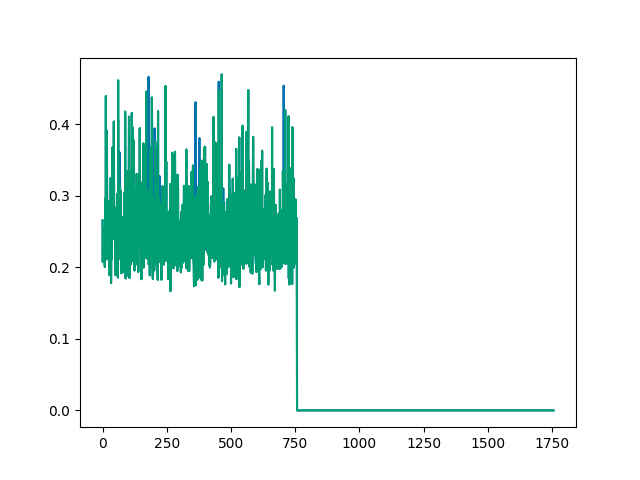

In [41]:
plt.figure()
plt.plot(J_min_scp_cvx_feas)
plt.plot(J_min_scp_DT_feas)

In [42]:


####### Testset analysis as function of CTGS0

ctgs_range = range(0, 51, 1)
test_dataset_size = np.zeros(shape=(len(ctgs_range),), dtype=int)
J_scp_percgain_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percgain_std_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percgain2_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percloss_cvx_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percloss_cvx_std_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percloss_DT_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_scp_percloss_DT_std_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_mean_cvx_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_mean_DT_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_std_cvx_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_std_DT_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_gain_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
iter_scp_gain_std_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 

runtime_mean_cvx_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_mean_DT_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_cvx_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_DT_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_mean_cvx_scp_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_mean_DT_scp_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_cvx_scp_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_DT_scp_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_mean_cvx_tot_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_mean_DT_tot_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_cvx_tot_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_std_DT_tot_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_gain_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
runtime_gain_std_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 

J_relgain_scp_cvx_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_relgain_scp_DT_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 
J_percgain_scp_DT_mean_ctgs = np.zeros(shape=(len(ctgs_range),), dtype=float) 

n_unfeas_scp_cvx = np.zeros(shape=(len(ctgs_range),), dtype=float)
n_unfeas_scp_DT = np.zeros(shape=(len(ctgs_range),), dtype=float)

ctgxx = 1

print('Testset analysis as function of CTGS0.')

iter = 0
for ctg in ctgs_range:

    i_ctg = list(set(np.rint(test_dataset_ix[ctgs0_cvx<ctg]).astype(int)))
    i_unfeas_plus_ctg = list(set(i_unfeas).union(set(i_ctg)))

    ctgs0_cvx_feas_ctg = np.delete(ctgs0_cvx, i_unfeas_plus_ctg, axis=0)
    J_vect_scp_cvx_feas_ctg = np.delete(J_vect_scp_cvx, i_unfeas_plus_ctg, axis=0)
    J_vect_scp_DT_feas_ctg = np.delete(J_vect_scp_DT, i_unfeas_plus_ctg, axis=0)
    J_cvx_feas_ctg = np.delete(J_cvx, i_unfeas_plus_ctg, axis=0)
    J_DT_feas_ctg = np.delete(J_DT, i_unfeas_plus_ctg, axis=0)
    iter_scp_cvx_feas_ctg = np.delete(iter_scp_cvx, i_unfeas_plus_ctg, axis=0)
    iter_scp_DT_feas_ctg = np.delete(iter_scp_DT, i_unfeas_plus_ctg, axis=0)
    runtime_cvx_feas_ctg = np.delete(runtime_cvx, i_unfeas_plus_ctg, axis=0)
    runtime_scp_cvx_feas_ctg = np.delete(runtime_scp_cvx, i_unfeas_plus_ctg, axis=0)
    runtime_DT_feas_ctg = np.delete(runtime_DT, i_unfeas_plus_ctg, axis=0)
    runtime_scp_DT_feas_ctg = np.delete(runtime_scp_DT, i_unfeas_plus_ctg, axis=0)

    if ctg == ctgxx:
        J_vect_scp_cvx_feas_ctgxx = J_vect_scp_cvx_feas_ctg
        J_vect_scp_DT_feas_ctgxx = J_vect_scp_DT_feas_ctg
        J_cvx_feas_ctgxx = J_cvx_feas_ctg
        J_DT_feas_ctgxx = J_DT_feas_ctg
        iter_scp_cvx_feas_ctgxx = iter_scp_cvx_feas_ctg
        iter_scp_DT_feas_ctgxx = iter_scp_DT_feas_ctg

    test_dataset_size[iter] = len(ctgs0_cvx_feas_ctg)
    print('CTGS0 > ', ctg, ' . Test dataset size: ', test_dataset_size[iter])
    J_min_scp_cvx_feas_ctg = np.min(J_vect_scp_cvx_feas_ctg, axis=1)
    J_avg_scp_cvx_feas_ctg = J_min_scp_cvx_feas_ctg.mean()*1000.
    J_min_scp_DT_feas_ctg = np.min(J_vect_scp_DT_feas_ctg, axis=1)
    J_avg_scp_DT_feas_ctg = J_min_scp_DT_feas_ctg.mean()*1000.
    J_avg_cvx_feas_ctg = J_cvx_feas_ctg.mean()*1000.

    J_scp_percgain_mean_ctgs[iter] = np.mean((J_min_scp_cvx_feas_ctg - J_min_scp_DT_feas_ctg)/J_min_scp_cvx_feas_ctg*100)
    J_scp_percgain_std_ctgs[iter] = np.std((J_min_scp_cvx_feas_ctg - J_min_scp_DT_feas_ctg)/J_min_scp_cvx_feas_ctg*100)
    print('J_scp_gain_mean_ctgs_' + str(ctg) + ': ', J_scp_percgain_mean_ctgs[iter], 'J_scp_gain_std_ctgs_' + str(ctg) + ': ', J_scp_percgain_std_ctgs[iter])

    J_scp_percgain2_mean_ctgs[iter] = np.mean((J_min_scp_cvx_feas_ctg - J_min_scp_DT_feas_ctg))/np.mean((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg))*100
    print('J_scp_gain2_mean_ctgs_' + str(ctg) + ': ', J_scp_percgain_mean_ctgs[iter])

    J_scp_percloss_cvx_mean_ctgs[iter] = np.mean((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
    J_scp_percloss_cvx_std_ctgs[iter] = np.std((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
    J_scp_percloss_DT_mean_ctgs[iter] = np.mean((J_min_scp_DT_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
    J_scp_percloss_DT_std_ctgs[iter] = np.std((J_min_scp_DT_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
    print('J_scp_percloss_cvx_mean_ctgs_' + str(ctg) + ': ', J_scp_percloss_cvx_mean_ctgs[iter], 'J_scp_percloss_cvx_std_ctgs_' + str(ctg) + ': ', J_scp_percloss_cvx_std_ctgs[iter])
    print('J_scp_percloss_DT_mean_ctgs_' + str(ctg) + ': ', J_scp_percloss_DT_mean_ctgs[iter], 'J_scp_percloss_DT_std_ctgs_' + str(ctg) + ': ', J_scp_percloss_DT_std_ctgs[iter])

    iter_scp_mean_cvx_ctgs[iter] = np.mean(iter_scp_cvx_feas_ctg)
    iter_scp_mean_DT_ctgs[iter] = np.mean(iter_scp_DT_feas_ctg)
    iter_scp_std_cvx_ctgs[iter] = np.std(iter_scp_cvx_feas_ctg)
    iter_scp_std_DT_ctgs[iter] = np.std(iter_scp_DT_feas_ctg)
    iter_scp_gain_mean_ctgs[iter] = np.mean(iter_scp_cvx_feas_ctg - iter_scp_DT_feas_ctg)
    iter_scp_gain_std_ctgs[iter] = np.std(iter_scp_cvx_feas_ctg - iter_scp_DT_feas_ctg)
    print('iter_gain_mean_' + str(ctg) + ': ', iter_scp_gain_mean_ctgs[iter], ' iter_gain_std_' + str(ctg) + ': ', iter_scp_gain_std_ctgs[iter])
    print('iter_scp_mean_cvx_' + str(ctg) + ': ', iter_scp_mean_cvx_ctgs[iter], ' iter_scp_std_cvx_' + str(ctg) + ': ', iter_scp_std_cvx_ctgs[iter])
    print('iter_scp_mean_DT_' + str(ctg) + ': ', iter_scp_mean_DT_ctgs[iter], ' iter_scp_std_DT_' + str(ctg) + ': ', iter_scp_std_DT_ctgs[iter])

    runtime_mean_cvx_ctgs[iter] = np.mean(runtime_cvx_feas_ctg)
    runtime_mean_DT_ctgs[iter] = np.mean(runtime_DT_feas_ctg)
    runtime_std_cvx_ctgs[iter] = np.std(runtime_cvx_feas_ctg)
    runtime_std_DT_ctgs[iter] = np.std(runtime_DT_feas_ctg)
    runtime_mean_cvx_scp_ctgs[iter] = np.mean(runtime_scp_cvx_feas_ctg)
    runtime_mean_DT_scp_ctgs[iter] = np.mean(runtime_scp_DT_feas_ctg)
    runtime_std_cvx_scp_ctgs[iter] = np.std(runtime_scp_cvx_feas_ctg)
    runtime_std_DT_scp_ctgs[iter] = np.std(runtime_scp_DT_feas_ctg)
    runtime_mean_cvx_tot_ctgs[iter] = np.mean(runtime_cvx_feas_ctg + runtime_scp_cvx_feas_ctg)
    runtime_mean_DT_tot_ctgs[iter] = np.mean(runtime_DT_feas_ctg + runtime_scp_DT_feas_ctg)
    runtime_std_cvx_tot_ctgs[iter] = np.std(runtime_cvx_feas_ctg + runtime_scp_cvx_feas_ctg)
    runtime_std_DT_tot_ctgs[iter] = np.std(runtime_DT_feas_ctg + runtime_scp_DT_feas_ctg)
    runtime_gain_mean_ctgs[iter] = np.mean((runtime_cvx_feas_ctg + runtime_scp_cvx_feas_ctg) - (runtime_DT_feas_ctg + runtime_scp_DT_feas_ctg))
    runtime_gain_std_ctgs[iter] = np.std((runtime_cvx_feas_ctg + runtime_scp_cvx_feas_ctg) - (runtime_DT_feas_ctg + runtime_scp_DT_feas_ctg))
    print('runtime_gain_mean_' + str(ctg) + ': ', runtime_gain_mean_ctgs[iter], ' runtime_gain_std_' + str(ctg) + ': ', runtime_gain_std_ctgs[iter])
    print('runtime_scp_mean_cvx_' + str(ctg) + ': ', runtime_mean_cvx_tot_ctgs[iter], ' runtime_scp_std_cvx_' + str(ctg) + ': ', runtime_std_cvx_tot_ctgs[iter])
    print('runtime_scp_mean_DT_' + str(ctg) + ': ', runtime_mean_DT_tot_ctgs[iter], ' runtime_scp_std_DT_' + str(ctg) + ': ', runtime_std_DT_tot_ctgs[iter])

    J_relgain_scp_cvx_mean_ctgs[iter] = J_avg_scp_cvx_feas_ctg - J_avg_cvx_feas_ctg
    J_relgain_scp_DT_mean_ctgs[iter] = J_avg_scp_DT_feas_ctg - J_avg_cvx_feas_ctg
    J_percgain_scp_DT_mean_ctgs[iter] = (J_avg_scp_cvx_feas_ctg - J_avg_scp_DT_feas_ctg) / (J_avg_scp_cvx_feas_ctg - J_avg_cvx_feas_ctg)
    # print("================= J_relgain_scp_cvx_mean_ctgs:", J_relgain_scp_cvx_mean_ctgs[iter])

    i_ctg2 = list(set(np.rint(test_dataset_ix[ctgs0_cvx>=ctg]).astype(int)))

    i_unfeas_scp_cvx_ctg = list(set(i_unfeas_scp_cvx).intersection(set(i_ctg2)))
    i_unfeas_scp_DT_ctg = list(set(i_unfeas_DT).intersection(set(i_ctg2)))
    
    n_unfeas_scp_cvx[iter] = (len(i_unfeas_scp_cvx_ctg)/len(i_ctg2))*100
    n_unfeas_scp_DT[iter] = (len(i_unfeas_scp_DT_ctg)/len(i_ctg2))*100

    iter += 1


Testset analysis as function of CTGS0.
CTGS0 >  0  . Test dataset size:  1628
J_scp_gain_mean_ctgs_0:  -3594.8154623489054 J_scp_gain_std_ctgs_0:  42571.825506036585
J_scp_gain2_mean_ctgs_0:  -3594.8154623489054
J_scp_percloss_cvx_mean_ctgs_0:  -inf J_scp_percloss_cvx_std_ctgs_0:  nan
J_scp_percloss_DT_mean_ctgs_0:  -inf J_scp_percloss_DT_std_ctgs_0:  nan
iter_gain_mean_0:  -5.452474548522665e+300  iter_gain_std_0:  inf
iter_scp_mean_cvx_0:  -5.452474548522665e+300  iter_scp_std_cvx_0:  inf
iter_scp_mean_DT_0:  1.8286240786240786  iter_scp_std_DT_0:  2.2635323493427166
runtime_gain_mean_0:  nan  runtime_gain_std_0:  nan
runtime_scp_mean_cvx_0:  4.208295800615587  runtime_scp_std_cvx_0:  4.663634119031711
runtime_scp_mean_DT_0:  nan  runtime_scp_std_DT_0:  nan
CTGS0 >  1  . Test dataset size:  757
J_scp_gain_mean_ctgs_1:  -0.06693336397925043 J_scp_gain_std_ctgs_1:  5.743621484147097
J_scp_gain2_mean_ctgs_1:  -0.06693336397925043
J_scp_percloss_cvx_mean_ctgs_1:  24.872238311856965 J_scp

/tmp/ipykernel_1025079/2701249568.py:86: RuntimeWarning: divide by zero encountered in divide
  J_scp_percloss_cvx_mean_ctgs[iter] = np.mean((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
/tmp/ipykernel_1025079/2701249568.py:86: RuntimeWarning: overflow encountered in multiply
  J_scp_percloss_cvx_mean_ctgs[iter] = np.mean((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
/tmp/ipykernel_1025079/2701249568.py:87: RuntimeWarning: divide by zero encountered in divide
  J_scp_percloss_cvx_std_ctgs[iter] = np.std((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
/tmp/ipykernel_1025079/2701249568.py:87: RuntimeWarning: overflow encountered in multiply
  J_scp_percloss_cvx_std_ctgs[iter] = np.std((J_min_scp_cvx_feas_ctg - J_cvx_feas_ctg)/J_cvx_feas_ctg*100)
/home/amir/freeflyer2/tr4ff/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_1025079/270124

ZeroDivisionError: division by zero

In [43]:

######################################################## Plotting

####### Full feasible nncvx testset analysis

# plt.figure()
# eb1 = plt.errorbar(np.linspace(1,iter_max_SCP,iter_max_SCP), Delta_J_mean_scp_cvx, yerr=Delta_J_std_scp_cvx, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='scp-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(np.linspace(1,iter_max_SCP,iter_max_SCP), Delta_J_mean_scp_DT, yerr=Delta_J_std_scp_DT, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='scp-DT')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel('Iterations [-]', fontsize=17)
# plt.ylabel(r'$\frac{J_i -J_{min}}{J_{min}}$', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/scp_deltacost.png')

# plt.figure()
# eb1 = plt.errorbar(np.linspace(1,iter_max_SCP,iter_max_SCP), Delta_J_mean_scp_cvx_2_cvx, yerr=Delta_J_std_scp_cvx_2_cvx, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='scp-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(np.linspace(1,iter_max_SCP,iter_max_SCP), Delta_J_mean_scp_DT_2_cvx, yerr=Delta_J_std_scp_DT_2_cvx, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='scp-DT')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel('Iterations [-]', fontsize=17)
# plt.ylabel(r'$\frac{J_i -J_{cvx}}{J_{cvx}} $', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/scp_deltacost_2_cvx.png')

# plt.figure()
# plt.plot(J_cvx_feas_sort*1000, perc_opt_loss_DT, 'k-', label='DT')
# plt.plot(J_cvx_feas_sort*1000, perc_opt_loss_scp_cvx, 'b-', label='scp-cvx')
# plt.plot(J_cvx_feas_sort*1000, perc_opt_loss_scp_DT, 'g-', label='scp-DT ')
# plt.xlabel(r'$ J_{cvx} $ [mm/s]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{.,min} -J_{cvx}}{J_{cvx}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_loss.png')

# plt.figure()
# # plt.plot(ctgs0_cvx_sort, perc_opt_loss_DT_ctgs, 'k-', label='DT')
# # plt.plot(ctgs0_cvx_sort, perc_opt_loss_scp_cvx_ctgs, 'b--o', label='scp-cvx')
# # plt.plot(ctgs0_cvx_sort, perc_opt_loss_scp_DT_ctgs, 'g--o', label='scp-DT ')
# plt.plot(ctgs0_cvx_sort, perc_cost_gain_ctgs, 'b-')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{scp-cvx,min} -J_{scp-DT,min}}{J_{scp-cvx,min}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# # plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_loss_ctgs_sort.png')

# plt.figure()
# plt.plot(ctgs0_cvx_sort, iter_gain_ctgs, 'b-')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ iter_{scp-cvx} - iter_{scp-DT} $ [-]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/iter_gain_ctgs_sort.png')

# plt.figure()
# plt.plot(ctgs0_cvx_sort, perc_runtime_gain_ctgs, 'b-')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ (t_{scp-cvx} - t_{scp-DT})/t_{scp-cvx}$ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_gain_ctgs_sort.png')

####### Testset analysis as function of CTGS0

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, J_scp_percgain_mean_ctgs, yerr=J_scp_percgain_std_ctgs, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4)
# eb1[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{min, scp, ws-cvx} -J_{min, scp, ws-ART}}{J_{min, scp, ws-cvx}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_gain_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, J_scp_percgain2_mean_ctgs, yerr=0, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4)
# eb1[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{min, scp, ws-cvx} -J_{min, scp, ws-ART}}{J_{min, scp, ws-cvx} -J_{cvx}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_gain2_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, J_scp_percloss_cvx_mean_ctgs, yerr=J_scp_percloss_cvx_std_ctgs, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='ws-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(ctgs_range, J_scp_percloss_DT_mean_ctgs, yerr=J_scp_percloss_DT_std_ctgs, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='ws-ART')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{min, scp} -J_{cvx}}{J_{cvx}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_loss_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, J_scp_percloss_cvx_mean_ctgs, yerr=0, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='ws-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(ctgs_range, J_scp_percloss_DT_mean_ctgs, yerr=0, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='ws-ART')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ \frac{J_{min, scp} -J_{cvx}}{J_{cvx}} $ [%]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_loss_std0_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, iter_scp_mean_cvx_ctgs, yerr=iter_scp_std_cvx_ctgs, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='ws-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(ctgs_range, iter_scp_mean_DT_ctgs, yerr=iter_scp_std_DT_ctgs, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='ws-ART')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ iter_{scp} $ [-]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/iter_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, iter_scp_gain_mean_ctgs, yerr=iter_scp_gain_std_ctgs, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4)
# eb1[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ iter_{scp, ws-cvx} - iter_{scp, ws-ART}$ [-]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/iter_gain_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, runtime_mean_cvx_tot_ctgs, yerr=runtime_std_cvx_tot_ctgs, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4, label='ws-cvx')
# eb1[-1][0].set_linestyle('--')
# eb2 = plt.errorbar(ctgs_range, runtime_mean_DT_tot_ctgs, yerr=runtime_std_DT_tot_ctgs, fmt='b--o', ecolor='b', elinewidth=1.5, capsize=4, label='ws-ART')
# eb2[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ t_{ws} + t_{scp} $ [s]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_ctgs_cumulative.png')

# plt.figure()
# eb1 = plt.errorbar(ctgs_range, runtime_gain_mean_ctgs, yerr=runtime_gain_std_ctgs, fmt='k--o', ecolor='k', elinewidth=1.5, capsize=4)
# eb1[-1][0].set_linestyle('--')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ (t_{ws} + t_{scp})_{cvx} - (t_{ws} + t_{scp})_{ART}$ [s]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_gain_ctgs_cumulative.png')

# plt.figure()
# plt.plot(ctgs_range, runtime_mean_cvx_tot_ctgs, 'k-', label = 'tot-cvx')
# plt.plot(ctgs_range, runtime_mean_DT_tot_ctgs, 'b-', label = 'tot-DT')
# plt.plot(ctgs_range, runtime_mean_cvx_scp_ctgs, 'k--', label = 'scp-cvx')
# plt.plot(ctgs_range, runtime_mean_DT_scp_ctgs, 'b--', label = 'scp-DT')
# plt.plot(ctgs_range, runtime_mean_cvx_ctgs, 'k-.', label = 'cvx')
# plt.plot(ctgs_range, runtime_mean_DT_ctgs, 'b-.', label = 'DT')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'$ runtime $ [s]', fontsize=17)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.grid(True)
# plt.legend(loc='best', fontsize=17)
# plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_comparison_ctgs_cumulative.png')

# plt.figure()
# plt.plot(ctgs_range, test_dataset_size, 'b-')
# plt.xlabel(r'$ C_{cvx}(t_0) $ [-]', fontsize=17)
# plt.ylabel(r'test dataset size [-]', fontsize=17)
# plt.grid(True)
# plt.savefig(root_folder + '/optimization/saved_files/plots/test_dataset_size_ctgs_cumulative.png')


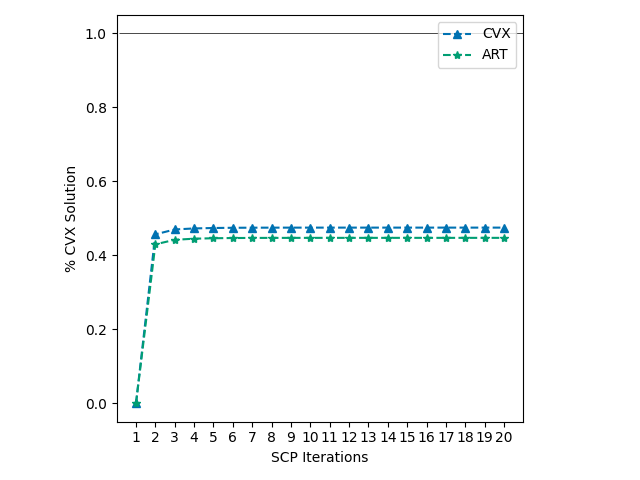

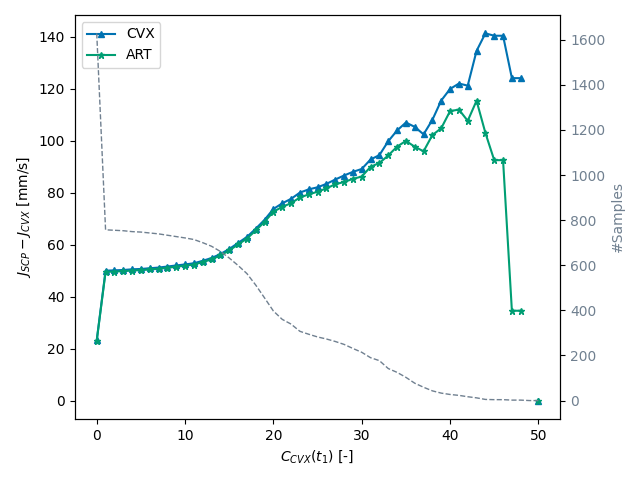

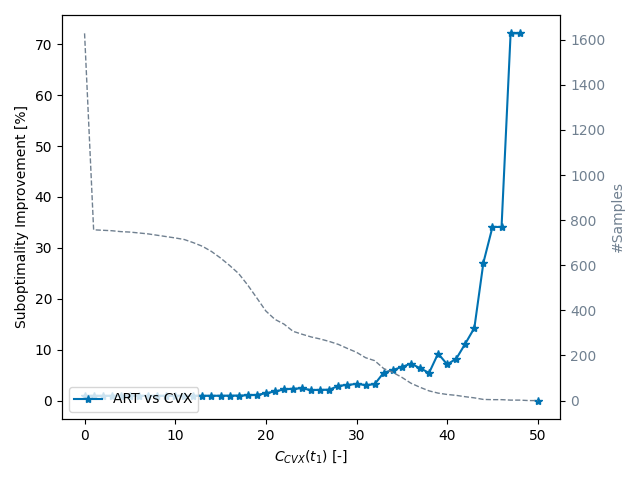

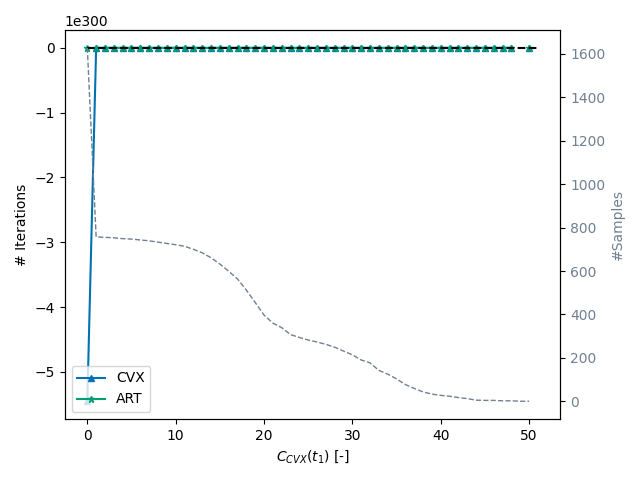

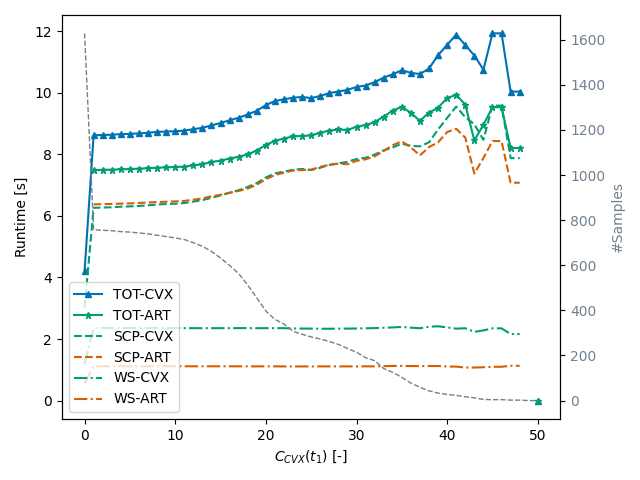

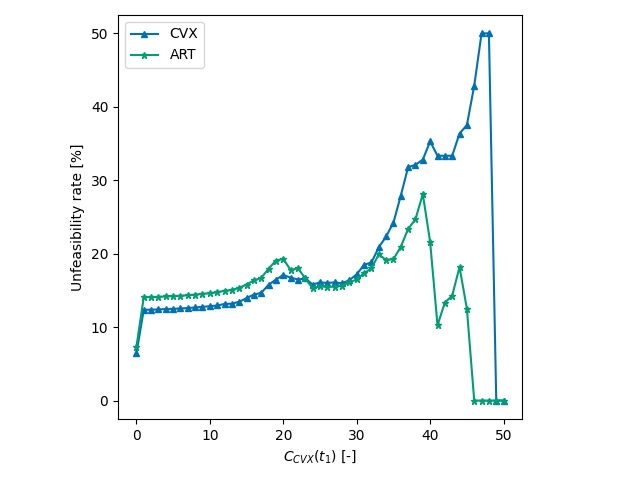

In [44]:
%matplotlib ipympl
plt.style.use('seaborn-v0_8-colorblind')

fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel(r'$C_{CVX}(t_1)$ [-]')
ax1.set_ylabel(r'$J_{SCP} - J_{CVX}$ [mm/s]', color='k')
ax1.plot(ctgs_range, J_relgain_scp_cvx_mean_ctgs, marker='^', markersize=5, label='CVX')
if rl:
    ax1.plot(ctgs_range, J_relgain_scp_DT_mean_ctgs, marker='*', markersize=5,  label='ART')
else:
    ax1.plot(ctgs_range, J_relgain_scp_DT_mean_ctgs, marker='*', markersize=5,  label='ART-IL')
ax1.tick_params(axis='y', labelcolor=color)
# plt.hlines(0, 0, 51, linestyle='--', color='k')
##plt.ylim([-0.05, 2.])
plt.legend(loc='best')
#plt.grid(True)
ax2 = ax1.twinx() 
color = 'slategray'
ax2.set_ylabel('#Samples', color=color)
ax2.plot(ctgs_range, test_dataset_size, color=color, linestyle='--', linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
if rl:
    plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_2axis_plot_rl.png', dpi = 600)
else:
    plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_2axis_plot_il.png', dpi = 600)

fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel(r'$C_{CVX}(t_1)$ [-]')
ax1.set_ylabel(r'Suboptimality Improvement [%]', color='k')
if rl:
    ax1.plot(ctgs_range, J_percgain_scp_DT_mean_ctgs*100., marker='*', label='ART vs CVX')
else:
    ax1.plot(ctgs_range, J_percgain_scp_DT_mean_ctgs*100., marker='*', label='ART-IL vs CVX')
ax1.tick_params(axis='y', labelcolor=color)
if rl:
    #plt.ylim([-1, 101.])
    plt.legend(loc='lower left')
else:
    #plt.ylim([-101, 101.])
    plt.legend(loc='lower left')
#plt.grid(True)
ax2 = ax1.twinx() 
color = 'slategray'
ax2.set_ylabel('#Samples', color=color)
ax2.plot(ctgs_range, test_dataset_size, color=color, linestyle='--', linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
if rl:
    plt.savefig(root_folder + '/optimization/saved_files/plots/perc_optimality_2axis_plot_rl.png', dpi = 600)
else:
    plt.savefig(root_folder + '/optimization/saved_files/plots/perc_optimality_2axis_plot_il.png', dpi = 600)

fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel(r'$C_{CVX}(t_1)$ [-]')
ax1.set_ylabel(r'# Iterations', color='k')
ax1.plot(ctgs_range, iter_scp_mean_cvx_ctgs, marker='^', markersize=5, label='CVX')
if rl:
    ax1.plot(ctgs_range, iter_scp_mean_DT_ctgs, marker='*', markersize=5,  label='ART')
else:
    ax1.plot(ctgs_range, iter_scp_mean_DT_ctgs, marker='*', markersize=5,  label='ART-IL')
ax1.tick_params(axis='y', labelcolor=color)
plt.hlines(1, 0, 51, linestyle='--', color='k')
#plt.ylim([0., 7.])
plt.legend(loc='lower left')
#plt.grid(True)
ax2 = ax1.twinx() 
color = 'slategray'
ax2.set_ylabel('#Samples', color=color)
ax2.plot(ctgs_range, test_dataset_size, color=color, linestyle='--', linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
if rl:
    plt.savefig(root_folder + '/optimization/saved_files/plots/iterations_2axis_plot_rl.png', dpi = 600)
else:
    plt.savefig(root_folder + '/optimization/saved_files/plots/iterations_2axis_plot_il.png', dpi = 600)

fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel(r'$C_{CVX}(t_1)$ [-]')
ax1.set_ylabel(r'Runtime [s]', color='k')
ax1.plot(ctgs_range, runtime_mean_cvx_tot_ctgs, marker='^', markersize=5, label='TOT-CVX')
if rl:
    ax1.plot(ctgs_range, runtime_mean_DT_tot_ctgs, marker='*', markersize=5,  label='TOT-ART')
else:
    ax1.plot(ctgs_range, runtime_mean_DT_tot_ctgs, marker='*', markersize=5,  label='TOT-ART-IL')
ax1.plot(ctgs_range, runtime_mean_cvx_scp_ctgs, linestyle='--', color='#009E73', label='SCP-CVX')
if rl:
    ax1.plot(ctgs_range, runtime_mean_DT_scp_ctgs, linestyle='--', color='#D55E00', label='SCP-ART')
else:
    ax1.plot(ctgs_range, runtime_mean_DT_scp_ctgs, linestyle='--', color='#D55E00', label='SCP-ART-IL')
ax1.plot(ctgs_range, runtime_mean_cvx_ctgs, linestyle='-.', color='#009E73', label='WS-CVX')
if rl:
    ax1.plot(ctgs_range, runtime_mean_DT_ctgs, linestyle='-.', color='#D55E00', label='WS-ART')
else:
    ax1.plot(ctgs_range, runtime_mean_DT_ctgs, linestyle='-.', color='orangered', label='WS-ART-IL')
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,2.5])
plt.legend(loc='lower left')
#plt.grid(True)
ax2 = ax1.twinx() 
color = 'slategray'
ax2.set_ylabel('#Samples', color=color)
ax2.plot(ctgs_range, test_dataset_size, color=color, linestyle='--', linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
if rl:
    plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_2axis_plot_rl.png', dpi = 600)
else:
    plt.savefig(root_folder + '/optimization/saved_files/plots/runtime_2axis_plot_il.png', dpi = 600)

fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel(r'$C_{CVX}(t_1)$ [-]')
ax1.set_ylabel(r'Unfeasibility rate [%]', color='k')
ax1.plot(ctgs_range, n_unfeas_scp_cvx, marker='^', markersize=5, label='CVX')
if rl:
    ax1.plot(ctgs_range, n_unfeas_scp_DT, marker='*', markersize=5,  label='ART')
else:
    ax1.plot(ctgs_range, n_unfeas_scp_DT, marker='*', markersize=5,  label='ART-IL')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='best')
#plt.ylim([-0.1,5])
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax1.set_aspect(asp)
#plt.grid(True)
# ax2 = ax1.twinx() 
# color = 'slategray'
# ax2.set_ylabel('#Samples', color=color)
# ax2.plot(ctgs_range, test_dataset_size, color=color, linestyle='--', linewidth=1)
# ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
if rl:
    plt.savefig(root_folder + '/optimization/saved_files/plots/unfeasible_2axis_plot_rl.png', dpi = 600)
else:
    plt.savefig(root_folder + '/optimization/saved_files/plots/unfeasible_2axis_plot_il.png', dpi = 600)


# Cost vs iterations analysis
for i, (row, it) in enumerate(zip(J_vect_scp_DT_feas_ctgxx, iter_scp_DT_feas_ctgxx)):
    J_vect_scp_DT_feas_ctgxx[i, int(it):] = row[int(it)-1]
for i, (row, it) in enumerate(zip(J_vect_scp_cvx_feas_ctgxx, iter_scp_cvx_feas_ctgxx)):
    J_vect_scp_cvx_feas_ctgxx[i, int(it):] = row[int(it)-1]
J_vect_scp_DT_avg_ctgxx = 1 - ((np.mean(J_vect_scp_DT_feas_ctgxx, axis=0) - np.mean(J_cvx_feas_ctgxx, axis=0)) / (np.mean(J_vect_scp_DT_feas_ctgxx, axis=0)[0] - np.mean(J_cvx_feas_ctgxx, axis=0)))
J_vect_scp_cvx_avg_ctgxx = 1 - ((np.mean(J_vect_scp_cvx_feas_ctgxx, axis=0) - np.mean(J_cvx_feas_ctgxx, axis=0)) / (np.mean(J_vect_scp_cvx_feas_ctgxx, axis=0)[0] - np.mean(J_cvx_feas_ctgxx, axis=0)))

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1, 21), J_vect_scp_cvx_avg_ctgxx, '--', marker='^', label='CVX')
ax1.plot(np.arange(1, 21), J_vect_scp_DT_avg_ctgxx, '--', marker='*', label='ART')
plt.hlines(1, 0.1, 21, color='k', linestyle='-', linewidth=0.5)
plt.legend()
#plt.ylim([-0.05, 1.05])
plt.xlim([0,21])
plt.xticks(np.arange(1, 21))
plt.xlabel('SCP Iterations')
plt.ylabel('% CVX Solution')
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax1.set_aspect(asp)
plt.tight_layout()
plt.savefig(root_folder + '/optimization/saved_files/plots/optimality_vs_iterations_2axis_plot.png', dpi = 600)

plt.show()


if save_plots:
    if rl:
        np.save('saved_files/plots/J_relgain_scp_cvx_mean_ctgs_rl.npy', J_relgain_scp_cvx_mean_ctgs)
        np.save('saved_files/plots/iter_scp_mean_cvx_ctgs.npy', iter_scp_mean_cvx_ctgs)
        np.save('saved_files/plots/runtime_mean_cvx_ctgs.npy', runtime_mean_cvx_ctgs)
        np.save('saved_files/plots/J_relgain_scp_DT_rl_mean_ctgs.npy', J_relgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/iter_scp_mean_DT_rl_ctgs.npy', iter_scp_mean_DT_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_rl_ctgs.npy', runtime_mean_DT_ctgs)
        np.save('saved_files/plots/runtime_mean_cvx_ctgs.npy', runtime_mean_cvx_ctgs)
        np.save('saved_files/plots/runtime_mean_cvx_scp_ctgs.npy', runtime_mean_cvx_scp_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_rl_scp_ctgs.npy', runtime_mean_DT_scp_ctgs)
        np.save('saved_files/plots/runtime_mean_cvx_tot_ctgs.npy', runtime_mean_cvx_tot_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_rl_tot_ctgs.npy', runtime_mean_DT_tot_ctgs)
        np.save('saved_files/plots/test_dataset_size.npy', test_dataset_size)
        np.save('saved_files/plots/J_percgain_scp_DT_rl_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/J_percgain_scp_DT_rl_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/J_percgain_scp_DT_rl_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/J_percgain_scp_DT_rl_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/J_percgain_scp_DT_rl_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)
        np.save('saved_files/plots/J_vect_scp_cvx_feas.npy', J_vect_scp_cvx_feas)
        np.save('saved_files/plots/J_vect_scp_DT_feas.npy', J_vect_scp_DT_feas)
        np.save('saved_files/plots/J_cvx_feas.npy', J_cvx_feas)
        np.save('saved_files/plots/iter_scp_cvx_feas.npy', iter_scp_cvx_feas)
        np.save('saved_files/plots/iter_scp_DT_feas.npy', iter_scp_DT_feas)
        
    else:
        np.save('saved_files/plots/J_relgain_scp_cvx_mean_ctgs_il.npy', J_relgain_scp_cvx_mean_ctgs)
        np.save('saved_files/plots/iter_scp_mean_DT_il_ctgs.npy', iter_scp_mean_DT_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_il_ctgs.npy', runtime_mean_DT_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_il_scp_ctgs.npy', runtime_mean_DT_scp_ctgs)
        np.save('saved_files/plots/runtime_mean_DT_il_tot_ctgs.npy', runtime_mean_DT_tot_ctgs)
        np.save('saved_files/plots/J_percgain_scp_DT_il_mean_ctgs.npy', J_percgain_scp_DT_mean_ctgs)

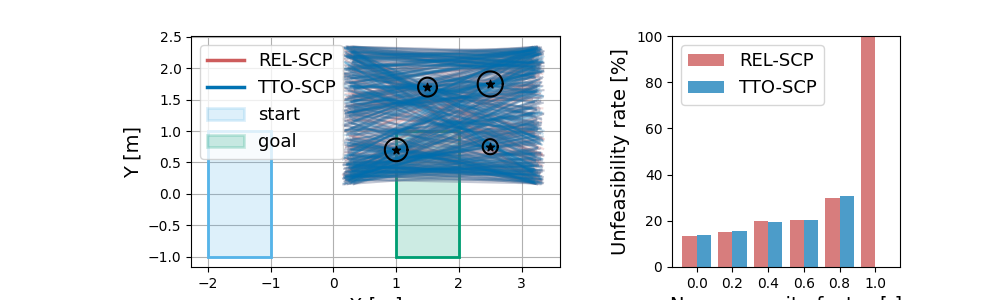

In [17]:
%matplotlib ipympl
from matplotlib.patches import Circle, Rectangle
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-v0_8-colorblind')
dim1 = 0
dim2 = 1
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,3)
ax = plt.subplot(gs[:,:2])
#ax.scatter3D(x_init_infeas_scp_cvx[:,0],x_init_infeas_scp_cvx[:,1],x_init_infeas_scp_cvx[:,2])
ax.plot(unfeas_lines[:,dim1,:].T, unfeas_lines[:,dim2,:].T, c='indianred', linewidth=1.5, alpha=0.2, zorder=3)#, unfeas_lines[:,2,:].T)
ax.plot(unfeas_lines_DT[:,dim1,:].T, unfeas_lines_DT[:,dim2,:].T, c='C0', linewidth=1.5, alpha=0.2, zorder=3)
ax.plot(0, 0, c='indianred', linewidth=2.5, label='REL-SCP')
ax.plot(0, 0, c='C0', linewidth = 2.5, label='TTO-SCP')
ax.add_patch(Rectangle((-2, -1), 1, 2, fc ='none', ec ='C5', alpha=1., lw = 2, zorder=2))
ax.add_patch(Rectangle((1, -1), 1, 2, fc ='none', ec ='C1', alpha=1., lw = 2, zorder=2))
ax.add_patch(Rectangle((-2, -1), 1, 2, fc ='C5', ec ='C5', alpha=0.2, lw = 2, zorder=2, label='start'))
ax.add_patch(Rectangle((1, -1), 1, 2, fc ='C1', ec ='C1', alpha=0.2, lw = 2, zorder=2, label='goal')) 
ax.set_aspect('equal')
for i in range(n_obs):
    p = obs['position'][i]
    r = obs['radius'][i]
    ax.scatter(p[dim1],p[dim2],marker='*',color='k', zorder=4)
    ax.plot(p[dim1]+r*np.cos(np.linspace(0,2*np.pi,100)), p[dim2]+r*np.sin(np.linspace(0,2*np.pi,100)), c='k', zorder=5)
ax.grid(True)
ax.set_xlabel('X [m]', fontsize=14)
ax.set_ylabel('Y [m]', fontsize=14)
ax.legend(loc='upper left', fontsize=13)

ax2 = plt.subplot(gs[:,2])
desampl = 10
categories = ctgs_range[::desampl]
values11 = n_unfeas_scp_cvx[:len(ctgs_range):desampl]  # First set of values
values21 = n_unfeas_scp_DT[:len(ctgs_range):desampl]   # Second set of values
x = np.array(categories)/5 # X-axis positions for each category
width = 0.8  # Width of each bar

ax2.bar(x - 0.5*width, values11, width, label='REL-SCP', color='indianred', alpha=0.8)
ax2.bar(x + 0.5*width, values21, width, label='TTO-SCP', color='C0', alpha=.7)

ax2.set_xticks(x)
ax2.set_ylim([0, 100])

ax2.set_xticklabels(x/10)
ax2.set_xlabel('Non-convexity factor [-]', fontsize=14)
ax2.set_ylabel('Unfeasibility rate [%]', fontsize=14)
ax2.legend(loc='upper left', fontsize=13)

fig.savefig('drone_minimum_results.svg')
plt.show()

In [ ]:
x, values11